In [80]:
import sys
sys.path.append(".")

import cv2
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt

from line_segmentation import compute_roi, line_segmentation #, cluster_lines

In [81]:
## Compute a lookahead point for the pure pursuit algorithm

In [82]:
PTS_IMAGE_PLANE = [[483, 210],
                   [244, 206],
                   [173, 249],
                   [584, 286]]

PTS_GROUND_PLANE = [[39, -13],
                    [39, 13],
                    [23, 13],
                    [23, -13]]

METERS_PER_INCH = 0.0254

np_pts_ground = np.array(PTS_GROUND_PLANE)
np_pts_ground = np_pts_ground * METERS_PER_INCH
np_pts_ground = np.float32(np_pts_ground[:, np.newaxis, :])

np_pts_image = np.array(PTS_IMAGE_PLANE)
np_pts_image = np_pts_image * 1.0
np_pts_image = np.float32(np_pts_image[:, np.newaxis, :])

# To this:
h, _ = cv2.findHomography(np_pts_image, np_pts_ground)

def transformUvToXy(u, v):
    """
    u and v are pixel coordinates.
    The top left pixel is the origin, u axis increases to right, and v axis
    increases down.

    Returns a normal non-np 1x2 matrix of xy displacement vector from the
    camera to the point on the ground plane.
    Camera points along positive x axis and y axis increases to the left of
    the camera.

    Units are in meters.
    """
    homogeneous_point = np.array([[u], [v], [1]])
    xy = np.dot(h, homogeneous_point)
    scaling_factor = 1.0 / xy[2, 0]
    homogeneous_xy = xy * scaling_factor
    x = homogeneous_xy[0, 0]
    y = homogeneous_xy[1, 0]
    return x, y


### Clustering based on distance between lines and angle, as well as length

Number of clusters found: 3

Cluster 0:
Number of lines: 4
Points (start_point, end_point):
  (83, 307) -> (282, 197)
  (11, 374) -> (206, 256)
  (11, 375) -> (165, 282)
  (114, 291) -> (278, 200)

Cluster 1:
Number of lines: 3
Points (start_point, end_point):
  (405, 162) -> (612, 225)
  (425, 166) -> (618, 221)
  (461, 178) -> (582, 215)

Cluster 2:
Number of lines: 2
Points (start_point, end_point):
  (456, 262) -> (614, 228)
  (460, 276) -> (639, 235)
Before filtering: [ 11 368 282 198] -3.6435837937202336
Before filtering: [405 161 618 224] 10.68520187753126
Before filtering: [456 268 639 229] -52.96370246676334
After filtering: [array([ 11, 368, 282, 198]), array([405, 161, 618, 224])]
0.23061636874413688, 0.28978871657640964
0.893882022858113, -0.5204864762091014
Left lines: [(1, 0.5204864762091014)], right lines: [(0, 0.28978871657640964)]
left_line=array([405, 161, 618, 224])
right_line=array([ 11, 368, 282, 198])


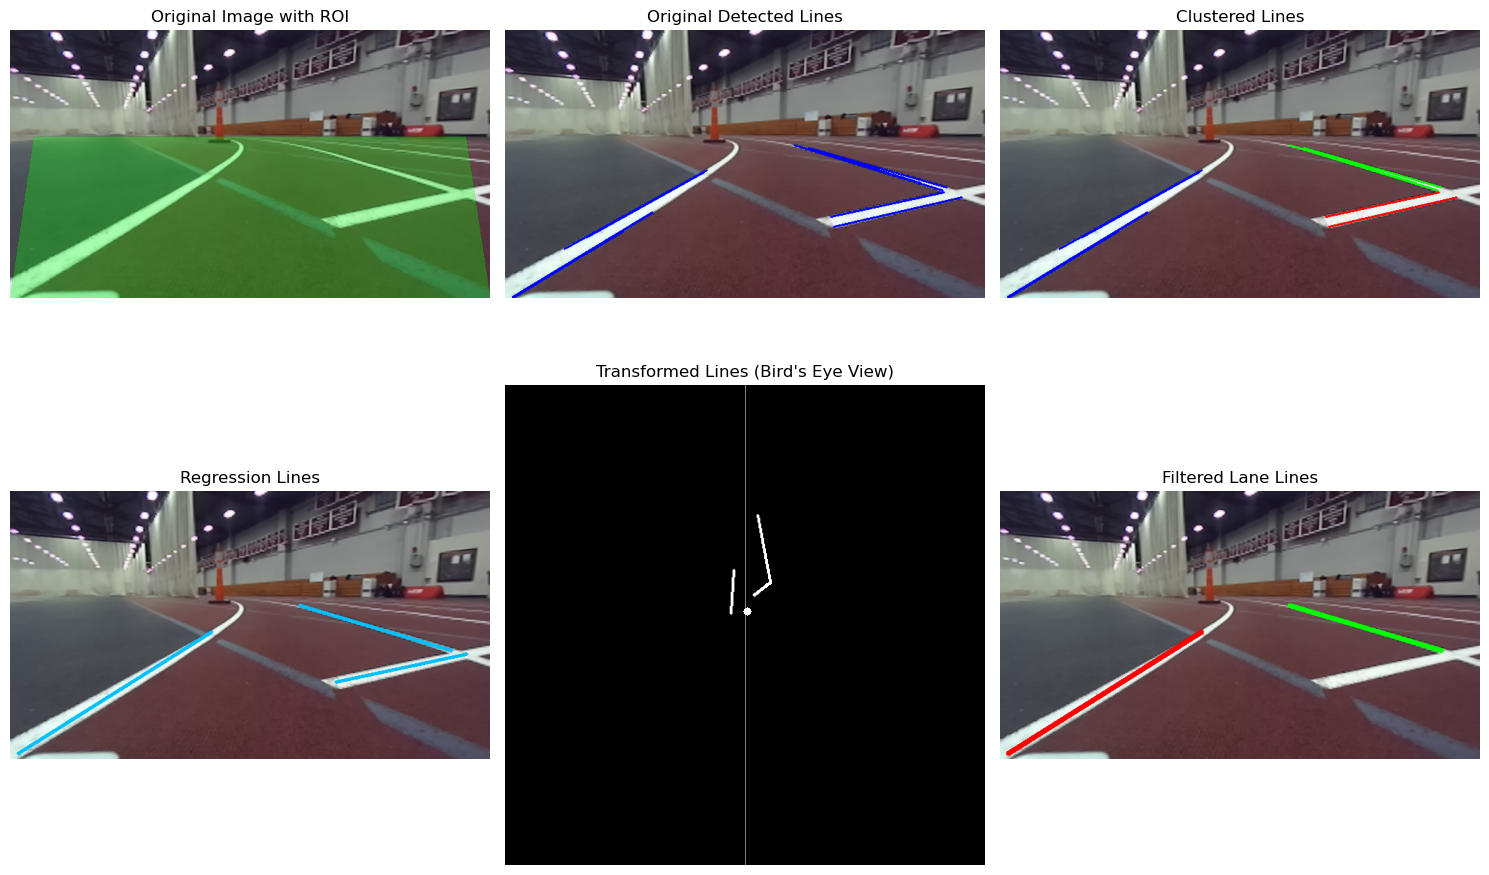

In [138]:
def point_to_line_distance(point, line_start, line_end):
    line_vec = line_end - line_start
    point_vec = point - line_start
    line_len = np.linalg.norm(line_vec)
    if line_len == 0:
        return np.linalg.norm(point_vec)
    
    # Calculate projection
    t = max(0, min(1, np.dot(point_vec, line_vec) / (line_len * line_len)))
    projection = line_start + t * line_vec
    return np.linalg.norm(point - projection)

def line_to_line_distance(line1, line2):
    p1 = np.array([line1[0], line1[1]])
    p2 = np.array([line1[2], line1[3]])
    p3 = np.array([line2[0], line2[1]])
    p4 = np.array([line2[2], line2[3]])
    
    distances = [
        point_to_line_distance(p1, p3, p4),
        point_to_line_distance(p2, p3, p4),
        point_to_line_distance(p3, p1, p2),
        point_to_line_distance(p4, p1, p2)
    ]
    return min(distances)

def select_lane_lines(regression_lines, angle_filter=-15):
    """
    Select the two lines that form the lane boundaries on either side of the vertical center line.
    Returns the left and right lane boundary lines.
    """
    if len(regression_lines) < 2:
        return None, None
        
    # Transform lines to bird's eye view coordinates
    transformed_lines = []
    filtered_lines = []
    for line in regression_lines:
        x1, y1, x2, y2 = line

        # Transform both points
        p1_t = transformUvToXy(x1, y1)
        p2_t = transformUvToXy(x2, y2)
        
        # Ensure x1 is the minimum x coordinate
        if p2_t[0] < p1_t[0]:
            x1_t, y1_t = p2_t
            x2_t, y2_t = p1_t
        else:
            x1_t, y1_t = p1_t
            x2_t, y2_t = p2_t
        
        # Calculate angle after transform
        angle = np.arctan2(y2_t - y1_t, x2_t - x1_t) * 180 / np.pi

        print(f"Before filtering: {line} {angle}")
        if angle > angle_filter:
            transformed_lines.append(((x1_t, y1_t), (x2_t, y2_t)))
            filtered_lines.append(line)
        
    print(f"After filtering: {filtered_lines}")
    
    if len(filtered_lines) < 2:
        return None, None
    
    # Find lines on either side of center (x=0)
    left_lines = []
    right_lines = []
    
    for i, ((x1, y1), _) in enumerate(transformed_lines):
        print(f"{x1}, {y1}")
        if y1 < 0:
            left_lines.append((i, abs(y1)))
        else:
            right_lines.append((i, abs(y1)))
    
    print(f"Left lines: {left_lines}, right lines: {right_lines}")
            
    # Select line closest to x-axis (y=0) on each side based on starting point
    left_idx = min(left_lines, key=lambda x: x[1])[0] if left_lines else None
    right_idx = min(right_lines, key=lambda x: x[1])[0] if right_lines else None
    
    left_line = filtered_lines[left_idx] if left_idx is not None else None
    right_line = filtered_lines[right_idx] if right_idx is not None else None
    
    return left_line, right_line

def cluster_lines(lines, distance_threshold=100, angle_threshold=10):
    if lines is None or len(lines) == 0:
        return [], []
    
    lines_array = np.array([line[0] for line in lines])
    
    # Calculate line angles
    angles = np.arctan2(lines_array[:, 3] - lines_array[:, 1], 
                       lines_array[:, 2] - lines_array[:, 0]) * 180 / np.pi
    angles = np.mod(angles + 180, 180)
    
    clusters = []
    used_lines = set()

    for i, line in enumerate(lines_array):
        if i in used_lines:
            continue
            
        current_cluster = [i]
        used_lines.add(i)
        
        # Compare with all other lines
        for j, other_line in enumerate(lines_array):
            if j in used_lines:
                continue
                
            # Check angle difference
            angle_diff = abs(angles[i] - angles[j])
            angle_diff = min(angle_diff, 180 - angle_diff)
            
            if angle_diff > angle_threshold:
                continue
                
            # Calculate minimum distance between lines
            distance = line_to_line_distance(line, other_line)
            
            if distance < distance_threshold:
                current_cluster.append(j)
                used_lines.add(j)
        
        clusters.append(current_cluster)
    
    final_lines = []
    regression_lines = []
    cluster_assignments = []
    
    for cluster_idx, cluster in enumerate(clusters):
        cluster_lines = lines_array[cluster]
        
        # Store cluster assignments
        for line_idx in cluster:
            cluster_assignments.append((line_idx, cluster_idx))
        
        # Average the endpoints for the cluster representation
        x1 = np.mean(cluster_lines[:, 0])
        y1 = np.mean(cluster_lines[:, 1])
        x2 = np.mean(cluster_lines[:, 2])
        y2 = np.mean(cluster_lines[:, 3])
        final_lines.append([int(x1), int(y1), int(x2), int(y2)])
        
        # Collect all points for regression
        points = np.vstack([
            cluster_lines[:, [0, 1]],  # Start points
            cluster_lines[:, [2, 3]]   # End points
        ])
        
        # Perform linear regression
        x = points[:, 0]
        y = points[:, 1]
        
        if len(x) > 1:  # Need at least 2 points for regression
            coeffs = np.polyfit(x, y, 1)
            
            # Find the extent of the line
            x_min = int(np.min(x))
            x_max = int(np.max(x))
            
            # Calculate corresponding y values
            y_min = int(coeffs[0] * x_min + coeffs[1])
            y_max = int(coeffs[0] * x_max + coeffs[1])
            
            regression_line = [x_min, y_min, x_max, y_max]
            regression_lines.append(regression_line)
    
    return np.array(final_lines), np.array(regression_lines), cluster_assignments

# Update the visualization code
image = cv2.imread("racetrack_images/lane_1/image4.png")
if image is None:
    raise IOError("Could not read the image.")

# Convert to HSV for better color segmentation of white
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])
mask = cv2.inRange(hsv, lower_white, upper_white)

roi_mask = compute_roi(mask)

# Apply ROI mask to the thresholded image
roi_result = cv2.bitwise_and(mask, roi_mask)

# Use Canny edge detection on the ROI result.
edges = cv2.Canny(roi_result, 50, 150)

# Use Probabilistic Hough Transform to detect line segments.
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi / 180, 
                        threshold=50, 
                        minLineLength=100, 
                        maxLineGap=10)
# Create 6 subplots (2 rows, 3 columns)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: ROI and original image
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
green_mask = np.zeros((*roi_mask.shape, 4))
green_mask[roi_mask > 0] = [0, 1, 0, 0.3]
ax1.imshow(green_mask)
ax1.set_axis_off()
ax1.set_title('Original Image with ROI')

# Plot 2: Original detected lines
line_image_original = image.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image_original, (x1,y1), (x2,y2), (255,0,0), 2)
ax2.imshow(cv2.cvtColor(line_image_original, cv2.COLOR_BGR2RGB))
ax2.set_axis_off()
ax2.set_title('Original Detected Lines')

# Plot 3: Clustered lines (different colors per cluster)
line_image_clustered = image.copy()
clustered_lines, regression_lines, cluster_assignments = clustered_lines = cluster_lines(
    lines=lines,
    distance_threshold=100,
    angle_threshold=10,
    )

cluster_colors = np.array([
    [255, 0, 0],    # Red
    [0, 255, 0],    # Green 
    [0, 0, 255],    # Blue
    [255, 255, 0],  # Yellow
    [255, 0, 255],  # Magenta
    [0, 255, 255],  # Cyan
    [128, 0, 0],    # Dark red
    [0, 128, 0],    # Dark green
    [0, 0, 128],    # Dark blue
    [128, 128, 0],  # Olive
])

# Print number of clusters and points in each cluster
num_clusters = len(set(cluster_idx for _, cluster_idx in cluster_assignments))
print(f"Number of clusters found: {num_clusters}")

# Group points by cluster
cluster_points = {i: [] for i in range(num_clusters)}
for line_idx, cluster_idx in cluster_assignments:
    line = lines[line_idx][0]
    cluster_points[cluster_idx].append(((line[0], line[1]), (line[2], line[3])))

# Print points in each cluster
for cluster_idx in range(num_clusters):
    print(f"\nCluster {cluster_idx}:")
    print(f"Number of lines: {len(cluster_points[cluster_idx])}")
    print("Points (start_point, end_point):")
    for start, end in cluster_points[cluster_idx]:
        print(f"  {start} -> {end}")

# Draw original lines with cluster colors
if lines is not None:
    for (line_idx, cluster_idx) in cluster_assignments:
        line = lines[line_idx][0]
        color = tuple(map(int, cluster_colors[cluster_idx]))
        cv2.line(line_image_clustered, (line[0], line[1]), (line[2], line[3]), color, 2)

robot_x = line_image_clustered.shape[1] // 2 
robot_y = line_image_clustered.shape[0] + 60 
cv2.circle(line_image_clustered, (robot_x, robot_y), 8, (255, 0, 0), -1)  # Draw filled blue circle

ax3.imshow(cv2.cvtColor(line_image_clustered, cv2.COLOR_BGR2RGB))
ax3.set_axis_off()
ax3.set_title('Clustered Lines')

# Plot 4: Regression lines
line_image_regression = image.copy()

# Get lane boundary lines
left_line, right_line = select_lane_lines(regression_lines)

print(f"{left_line=}")
print(f"{right_line=}")


# Draw all regression lines in yellow
for line in regression_lines:
    x1, y1, x2, y2 = line
    cv2.line(line_image_regression, (x1,y1), (x2,y2), (255,191,0), 3)

# Draw robot position on regression image too
cv2.circle(line_image_regression, (robot_x, robot_y), 8, (255, 0, 0), -1)

ax4.imshow(cv2.cvtColor(line_image_regression, cv2.COLOR_BGR2RGB))
ax4.set_axis_off()
ax4.set_title('Regression Lines')

# Plot 5: Transformed regression lines
transformed_canvas = np.zeros((500, 500))  # Adjust size as needed
scale_factor = 50 
# Transform and plot each regression line
for line in regression_lines:
    x1, y1, x2, y2 = line
    #print(x1, y1, x2, y2)
    # Transform endpoints using homography
    x1_t, y1_t = transformUvToXy(x1, y1)
    x2_t, y2_t = transformUvToXy(x2, y2)
    #print(x1_t)
    
    center_x, center_y = transformed_canvas.shape[1]//2, transformed_canvas.shape[0]//2
    
    # Rotate line 90 degrees by swapping x and y coordinates and negating one axis
    pt1 = (int(-y1_t * scale_factor + center_x), int(-x1_t * scale_factor + center_y))
    pt2 = (int(-y2_t * scale_factor + center_x), int(-x2_t * scale_factor + center_y))
    
    cv2.line(transformed_canvas, pt1, pt2, 255, 2)

# Draw center line
cv2.line(transformed_canvas, 
         (transformed_canvas.shape[1]//2, 0),
         (transformed_canvas.shape[1]//2, transformed_canvas.shape[0]),
         128, 1)

# Draw robot position in transformed view
robot_x_t, robot_y_t = transformUvToXy(robot_x, robot_y)
transformed_robot_x = int(-robot_y_t * scale_factor + center_x)
transformed_robot_y = int(-robot_x_t * scale_factor + center_y)
cv2.circle(transformed_canvas, (transformed_robot_x, transformed_robot_y), 4, 255, -1)

ax5.imshow(transformed_canvas, cmap='gray')
ax5.set_axis_off()
ax5.set_title('Transformed Lines (Bird\'s Eye View)')

# Plot 6: Filtered lane lines only
filtered_line_image = image.copy()

# Draw only the selected lane boundary lines
if left_line is not None:
    x1, y1, x2, y2 = left_line
    cv2.line(filtered_line_image, (x1,y1), (x2,y2), (0,255,0), 5)  # Green
if right_line is not None:
    x1, y1, x2, y2 = right_line
    cv2.line(filtered_line_image, (x1,y1), (x2,y2), (0,0,255), 5)  # Red

# Draw robot position
cv2.circle(filtered_line_image, (robot_x, robot_y), 8, (255, 0, 0), -1)

ax6.imshow(cv2.cvtColor(filtered_line_image, cv2.COLOR_BGR2RGB))
ax6.set_axis_off()
ax6.set_title('Filtered Lane Lines')

plt.tight_layout()

In [4]:
## Region of interest should be homography matrix, then we select lines 